# Dating Prediction

## Loading Data

In [184]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression

df = pd.read_csv("profiles.csv")

print(df.head())
print(df.columns)

   age       body_type               diet    drinks      drugs  \
0   22  a little extra  strictly anything  socially      never   
1   35         average       mostly other     often  sometimes   
2   38            thin           anything  socially        NaN   
3   23            thin         vegetarian  socially        NaN   
4   29        athletic                NaN  socially      never   

                           education  \
0      working on college/university   
1              working on space camp   
2     graduated from masters program   
3      working on college/university   
4  graduated from college/university   

                                              essay0  \
0  about me:<br />\n<br />\ni would love to think...   
1  i am a chef: this is what that means.<br />\n1...   
2  i'm not ashamed of much, but writing public te...   
3          i work in a library and go to school. . .   
4  hey how's it going? currently vague on the pro...   

                         

Mapping value to int

In [185]:
# Mapping str values to numerical
df["drinks"] = df["drinks"].replace(np.nan,'not at all',regex=True)
df["drinks_code"] = df.drinks.map({
    "not at all" : 0,
    "rarely" : 1,
    "socially" : 2,
    "often" : 3,
    "very often" : 4,
    "desperately" : 5
})

df["smokes"] = df["smokes"].replace(np.nan,'no',regex=True)
df["smokes_code"] = df.smokes.map({
    "no":0,
    "sometimes":1,
    "when drinking":2,
    "yes":3,
    "trying to quit":4
})

df["drugs"] = df["drugs"].replace(np.nan,'never',regex=True)
df["drugs_code"] = df.drugs.map({
    "never":0,
    "sometimes":1,
    "often":2
})

Mapping essays columns

In [186]:
# Retrieve the essays cols
essays_cols = ["essay0","essay1","essay2","essay3","essay4","essay5",
               "essay6","essay7","essay8","essay9"]

# Removing the NaNs
all_essays = df[essays_cols].replace(np.nan,'',regex=True)

# Combining the essays
all_essays = all_essays.apply(lambda x:' '.join(x),axis=1)

# Total length of the ssays
df["essay_len"] = all_essays.apply(lambda x : len(x))

# Average length for essays
df["avg_word_length"] = df["essay_len"]/len(essays_cols)

# Frequency of the words 'I' or 'me"
df["common_words"] = all_essays.str.count(r'\b(I|me)\b', flags=re.IGNORECASE)

### Normalize Data

In [187]:
feature_data = df[["smokes_code","drinks_code","drugs_code",
                   "essay_len","avg_word_length"]]

x = feature_data.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

### Predict Zodiac Signs

In [188]:
df["sign"] = df["sign"].replace(np.nan,'',regex=True)

# Only take the first word, which is the zodiac sign only
df["sign"] = (df["sign"].apply(lambda x: x.split(" ")[0]))

# X_train, X_test, y_train, y_test = train_test_split(feature_data,df["sign"],test_size=0.2,random_state=100)

# accuracies = []

# for k in range(1,100):
#     classifier = KNeighborsClassifier(n_neighbors=k)
#     classifier.fit(X_train,y_train)
#     accuracies.append(classifier.score(X_test,y_test))

# k_list = range(1,100)

# plt.plot(k_list,accuracies)
# plt.title("K-Neighbors Predict Zodiac Sign on smokes_code, drinks_code, drugs_code, essay_len, avg_word_length")
# plt.xlabel("k")
# plt.ylabel("Accuracy")

# plt.savefig("k_accuracy.png")
# plt.show()

## Classification Techniques

### Predict Sex with education level and income using K Nearest Neighbors

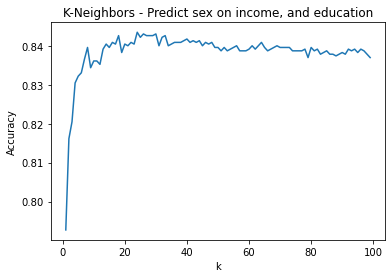

In [189]:
# Male = 0 , Female = 1
df["sex_code"] = df.sex.map({
    "m": 0,
    "f": 1
})

df["sex_code"].head()

# Remove rows with missing income
df = df[df["income"] != -1]

# Change the education category string to int type
label_encoder = preprocessing.LabelEncoder()
df["education_code"] = label_encoder.fit_transform(df["education"])

X = df[["income", "education_code"]]
y = df["sex_code"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=5)

accuracies = []

for k in range(1, 100):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train, y_train)
    classifier.score(X_test, y_test)
    accuracies.append(classifier.score(X_test, y_test))

k_list = range(1, 100)

plt.plot(k_list, accuracies)
plt.title("K-Neighbors - Predict sex on income, and education")
plt.xlabel("k")
plt.ylabel("Accuracy")

plt.savefig("sex_income-education.png")
plt.show()


### Predict Sex with education level and income using Decision Trees

graduated from college/university    4213
graduated from masters program       1509
working on college/university        1387
graduated from high school            563
graduated from two-year college       511
working on two-year college           392
dropped out of college/university     360
working on masters program            253
graduated from ph.d program           219
working on ph.d program               187
graduated from space camp             180
dropped out of space camp             156
graduated from law school             152
college/university                    133
working on space camp                 115
dropped out of two-year college        92
two-year college                       57
dropped out of high school             48
graduated from med school              42
dropped out of masters program         34
high school                            33
working on med school                  32
dropped out of ph.d program            26
working on high school            

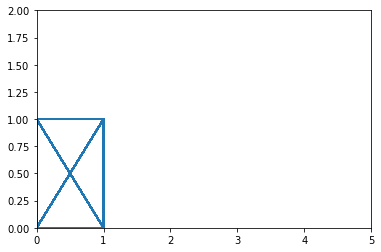

### Predict education level with essay text word counts

## Regression Techniques

### Predict income with length of essays and average word length

Train score:  2.251344143233691e-05
Test score:  -0.0015134372825655884


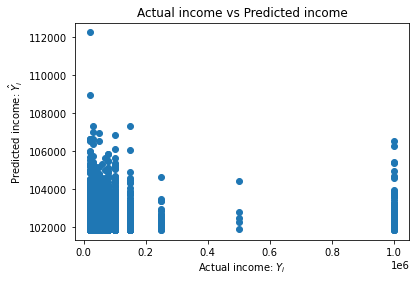

In [191]:
features = df[["essay_len","avg_word_length"]]

X_train, X_test, y_train, y_test = train_test_split(features,df["income"],train_size=0.8,test_size=0.2,random_state=6)
classifier = LinearRegression()
classifier.fit(X_train,y_train)
income_predict = classifier.predict(X_test)

print("Train score: ", classifier.score(X_train,y_train))
print("Test score: ", classifier.score(X_test,y_test))

plt.scatter(y_test,income_predict)
# plt.plot(range(20000),range(20000))

plt.xlabel("Actual income: $Y_i$")
plt.ylabel("Predicted income: $\hat{Y}_i$")
plt.title("Actual income vs Predicted income")

plt.show()
